In [2]:
# 從網上載入股票數據
import yfinance as yf
df = yf.Ticker("2454.TW").history(period="max")
df = df[df.notna()]

In [2]:
# 提取資料庫數據
datavalue = df.to_numpy()[:,:4]

In [3]:
# 歸一化
from sklearn import preprocessing
for i in range(datavalue.shape[1]):
    datavalue[:,i] = preprocessing.MinMaxScaler().fit_transform(datavalue[:,i].reshape(-1,1)).reshape(-1)

In [4]:
# 一次訓練參考的天數
time_length = 40

In [5]:
# 將資料每20天一組，步長為 1 
import numpy as np
x_data, y_data = [], []
for i in range(len(datavalue)-time_length):
    x_data.append(datavalue[i:i+time_length])
    y_data.append(datavalue[i+time_length])

x_data = np.array(x_data, dtype=np.float64)
y_data = np.array(y_data, dtype=np.float64)

In [6]:
# 測試集數量
test_length = 100

In [7]:
x_train = x_data[test_length:]
y_train = y_data[test_length:]
x_test = x_data[:test_length]
y_test = y_data[:test_length]
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (5014, 40, 4)
y_train: (5014, 4)
x_test: (100, 40, 4)
y_test: (100, 4)


In [8]:
# 對訓練集和測試集洗牌
s1 = np.arange(len(x_data)-test_length)
np.random.shuffle(s1)
x_train_shuffle = x_train[s1]
y_train_shuffle = y_train[s1]

s2 = np.arange(test_length)
np.random.shuffle(s2)
x_test_shuffle = x_test[s2]
y_test_shuffle = y_test[s2]

In [9]:
# 建立模型
import keras.layers as layers
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

def build_model(time_length, lr):
    
    input_layer = layers.Input(shape=(time_length, 4))

    # 第一層(LSTM)
    layer1 = layers.LSTM(256, return_sequences=True)(input_layer)
    layer1 = layers.Dropout(0.3)(layer1)

    # 第二層(LSTM)
    layer2 = layers.LSTM(256, return_sequences=False)(layer1)
    layer2 = layers.Dropout(0.3)(layer2)

    # 第三層(Dense)
    layer3 = layers.Dense(16,kernel_initializer="uniform",activation='relu')(layer2)

    # 第四層(Dense)
    layer4 = layers.Dense(4,kernel_initializer="uniform",activation='linear')(layer3)

    model = Model(inputs=input_layer, outputs=layer4)

    opt = Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    return model       

In [10]:
#batch_size (批次量)和 epochs (訓練次數)
batch_size = 128
epochs = 100

In [11]:
# 學習速率為 0.001
model = build_model(time_length, 0.001)

In [12]:
# 訓練模型
model.fit(x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs=epochs)

Epoch 1/100
40/40 [==============================] - 5s 24ms/step - loss: 0.0275 - mae: 0.0924
Epoch 2/100
40/40 [==============================] - 1s 23ms/step - loss: 7.3911e-04 - mae: 0.0170
Epoch 3/100
40/40 [==============================] - 1s 23ms/step - loss: 5.1851e-04 - mae: 0.0144
Epoch 4/100
40/40 [==============================] - 1s 25ms/step - loss: 6.7017e-04 - mae: 0.0162
Epoch 5/100
40/40 [==============================] - 1s 24ms/step - loss: 4.8522e-04 - mae: 0.0138
Epoch 6/100
40/40 [==============================] - 1s 22ms/step - loss: 4.4979e-04 - mae: 0.0131
Epoch 7/100
40/40 [==============================] - 1s 23ms/step - loss: 4.5140e-04 - mae: 0.0131
Epoch 8/100
40/40 [==============================] - 1s 23ms/step - loss: 4.9492e-04 - mae: 0.0136
Epoch 9/100
40/40 [==============================] - 1s 23ms/step - loss: 3.8409e-04 - mae: 0.0120
Epoch 10/100
40/40 [==============================] - 1s 23ms/step - loss: 4.0356e-04 - mae: 0.0122
Epoch 11/100


40/40 [==============================] - 1s 22ms/step - loss: 2.0023e-04 - mae: 0.0081
Epoch 84/100
40/40 [==============================] - 1s 22ms/step - loss: 1.8456e-04 - mae: 0.0079
Epoch 85/100
40/40 [==============================] - 1s 22ms/step - loss: 1.7232e-04 - mae: 0.0075
Epoch 86/100
40/40 [==============================] - 1s 22ms/step - loss: 2.0570e-04 - mae: 0.0084
Epoch 87/100
40/40 [==============================] - 1s 22ms/step - loss: 2.2523e-04 - mae: 0.0084
Epoch 88/100
40/40 [==============================] - 1s 22ms/step - loss: 1.9767e-04 - mae: 0.0082
Epoch 89/100
40/40 [==============================] - 1s 22ms/step - loss: 3.2086e-04 - mae: 0.0102
Epoch 90/100
40/40 [==============================] - 1s 22ms/step - loss: 1.9145e-04 - mae: 0.0082
Epoch 91/100
40/40 [==============================] - 1s 22ms/step - loss: 1.8699e-04 - mae: 0.0080
Epoch 92/100
40/40 [==============================] - 1s 22ms/step - loss: 1.9751e-04 - mae: 0.0081
Epoch 93/100


4/4 [==============================] - 0s 5ms/step


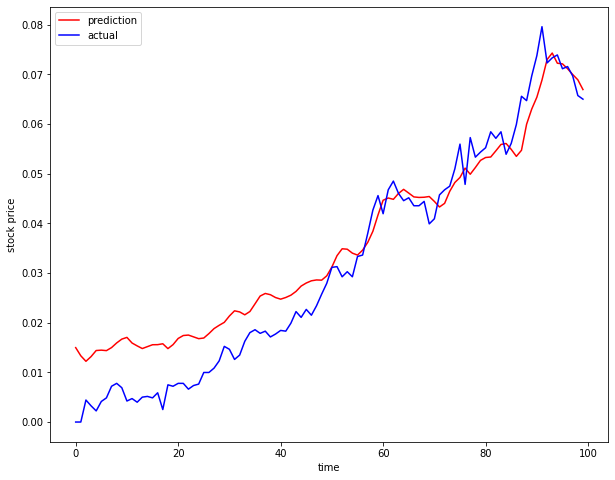

In [14]:
# 查看測試樣本的預測結果
p = model.predict(x_test)
plt.figure(figsize=(10,8))
plt.plot(p[:,3], color='r', label='prediction')
plt.plot(y_test[:,3], color='b', label='actual')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

In [15]:
# 用預測出來的結果預測之後的未來
x_start = x_test[-7]
x = x_start
res = []
for i in range(7):
    p = model.predict(x.reshape(1,-1,4), verbose=0)
    res.append(p)
    x = np.concatenate((x[1:], p))

res = np.array(res)

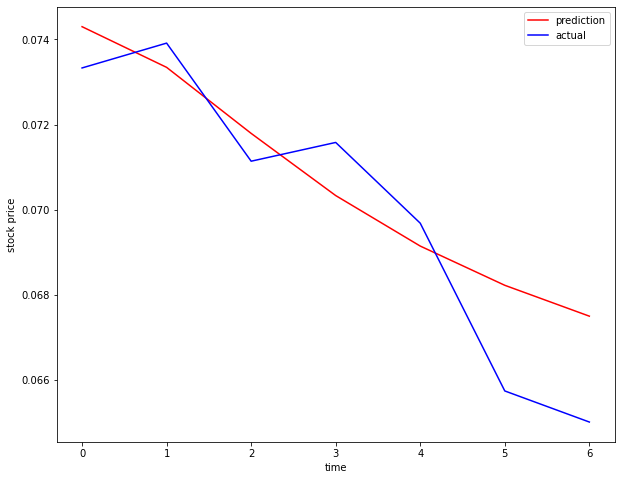

In [16]:
plt.figure(figsize=(10,8))
plt.plot(res[:,0,3], color='r', label='prediction')
plt.plot(y_test[-7:,3], color='b', label='actual')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()